In [ ]:
import os
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import zipfile
import random
import seaborn as sns
import warnings
import shutil
import cv2
from google.colab import files
from google.colab import drive
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount ke google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the destination directory if it doesn't exist

os.makedirs('/root/.kaggle/', exist_ok=True)

# Now copy the file
shutil.copy('/content/drive/MyDrive/Klasifikasi Papaya/kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d nurhafiizah/papaya-datasets

Dataset URL: https://www.kaggle.com/datasets/nurhafiizah/papaya-datasets
License(s): MIT
papaya-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# prompt: ekstrak filezip dan buat foldernya

# Extract the zip file
zip_ref = zipfile.ZipFile('/content/papaya-datasets.zip', 'r')
zip_ref.extractall('/content/papaya-datasets')
zip_ref.close()


In [ ]:
# Set basepath
basepath = "/content/papaya-datasets/Citra Papaya/papaya_image"

In [ ]:
def hitung_gambar_dalam_direktori(direktori):
    """
    Fungsi ini akan menghitung jumlah gambar dalam direktori yang diberikan.

    Args:
        direktori (str): Path ke direktori yang berisi gambar.

    Returns:
        int: Jumlah gambar yang ditemukan.
    """

    jumlah_gambar = 0
    for root, _, files in os.walk(direktori):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                jumlah_gambar += 1

    return jumlah_gambar

# Contoh penggunaan
total_gambar = hitung_gambar_dalam_direktori(basepath)
print("Jumlah gambar dalam direktori:", total_gambar)

Jumlah gambar dalam direktori: 500


In [ ]:
# Membuat list untuk menyimpan data
data = []

# Menentukan nilai target untuk setiap kategori dan mengganti nama kategori
category_dict = {
    'unmature': 'mentah',
    'partiallymature': 'mengkal',
    'mature': 'matang'
}

target_dict = {
    'mentah': 0,
    'mengkal': 1,
    'matang': 2
}

# Loop melalui setiap folder dalam main_folder
for original_category in category_dict.keys():
    category_path = os.path.join(basepath, original_category)
    if os.path.exists(category_path):  # Memeriksa apakah folder ada
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            category = category_dict[original_category]
            # Menambahkan informasi file ke dalam list data
            data.append({
                'filename': file_name,
                'category': category,
                'target': target_dict[category],
                'filepath': file_path
            })

# Membuat dataframe dari data
df = pd.DataFrame(data)

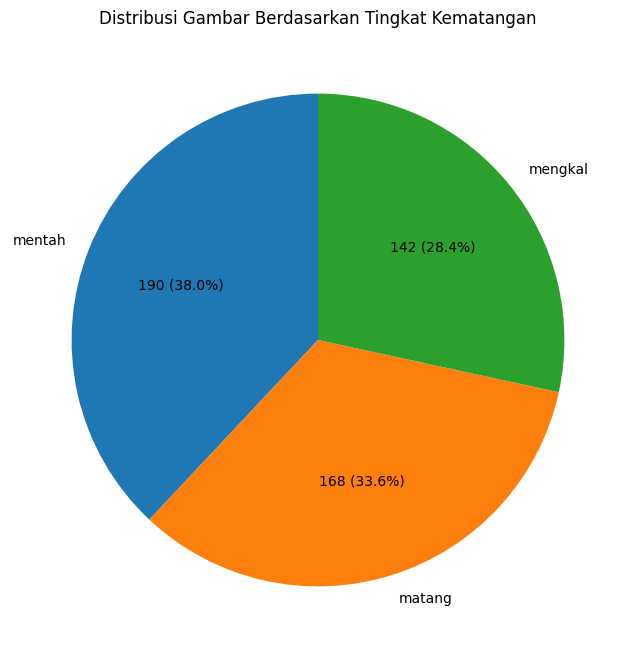

In [ ]:
# Asumsikan Anda sudah memiliki DataFrame 'df' dengan kolom 'category'

# Hitung jumlah gambar per kategori
data = df['category'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p*sum(data)/100, p), startangle=90)
plt.title('Distribusi Gambar Berdasarkan Tingkat Kematangan')
plt.show()

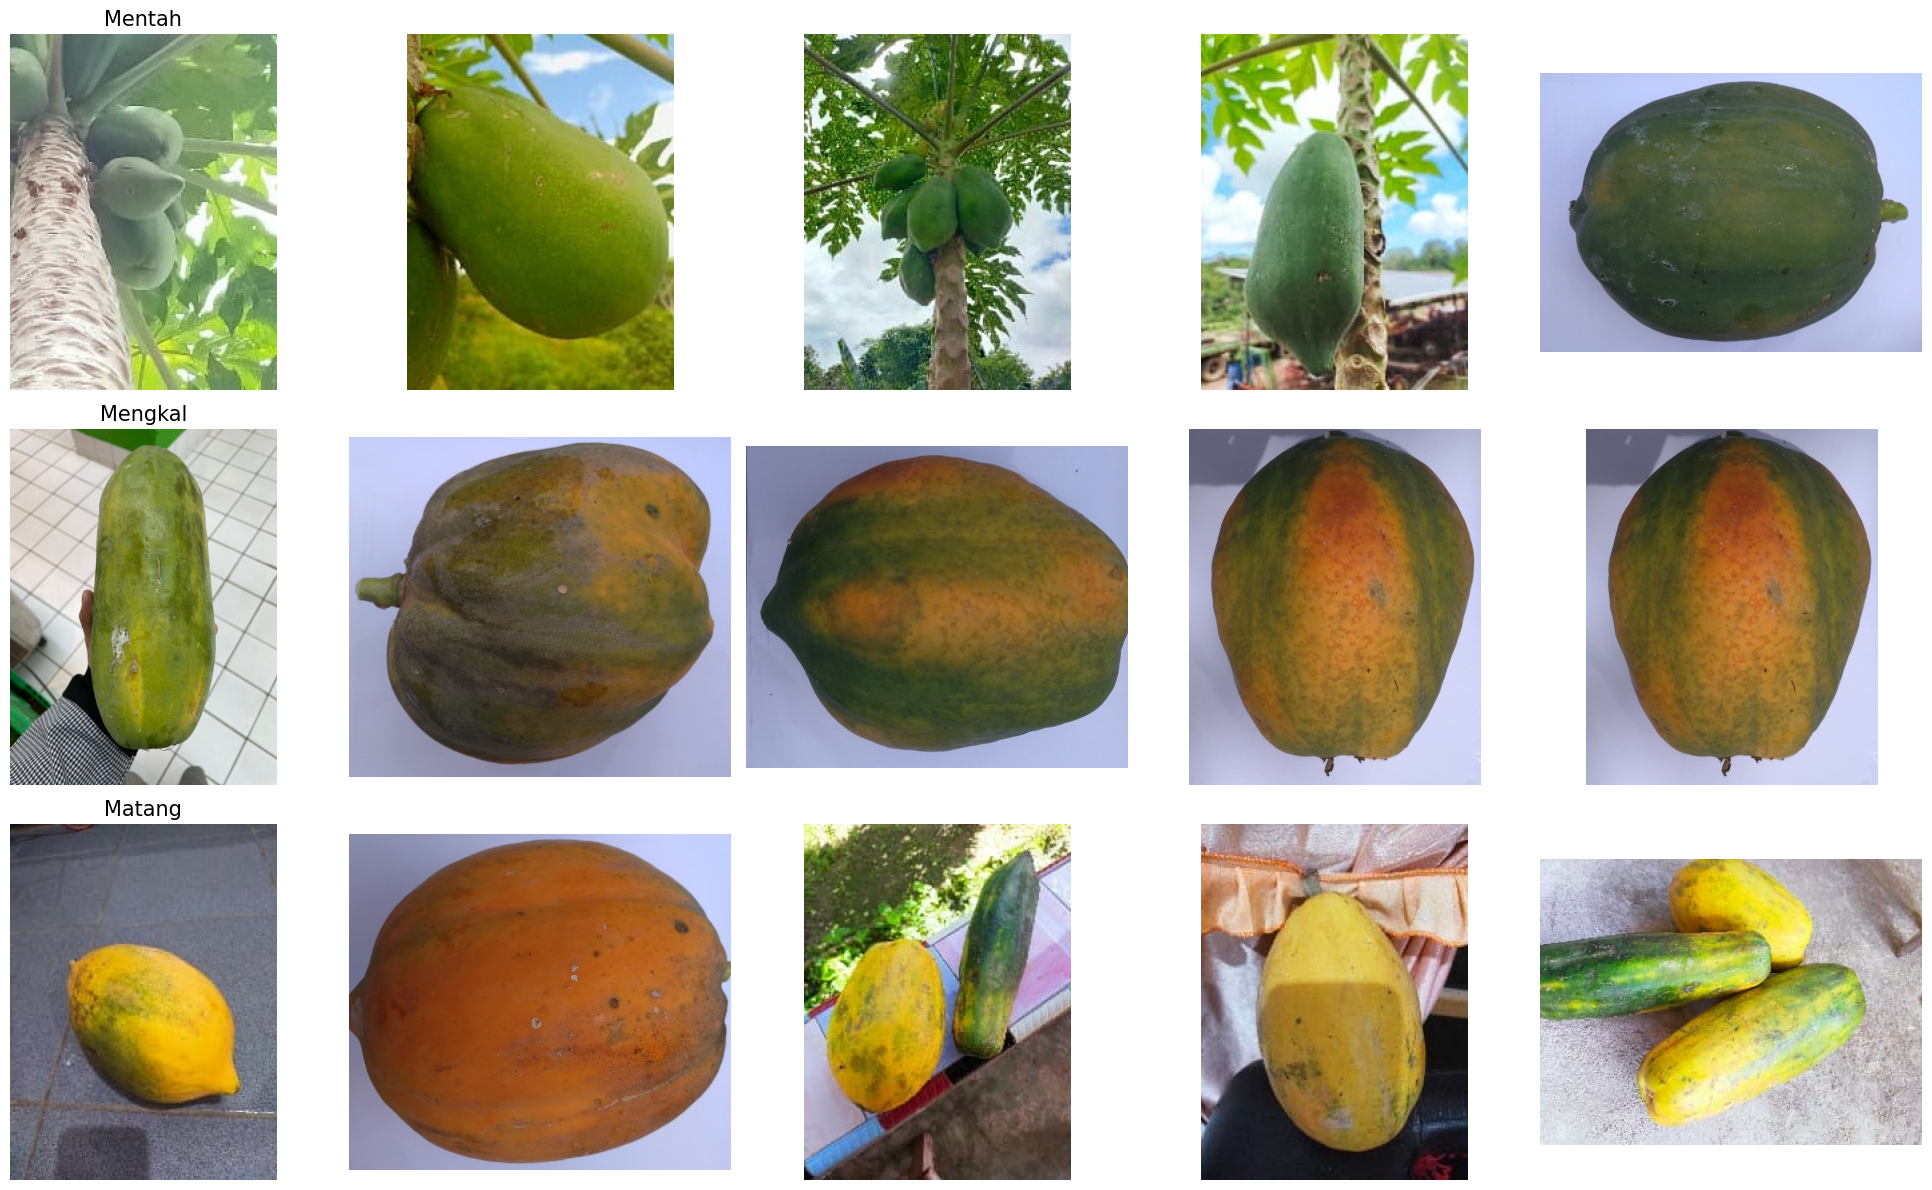

In [ ]:
# Menampilkan 5 gambar berdasarkan masing-masing tingkat kematangan
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i, category in enumerate(['mentah', 'mengkal', 'matang']):
    # Mengambil 5 gambar pertama dari kategori ini
    subset = df[df['category'] == category].head(5)
    for j, (index, row) in enumerate(subset.iterrows()):
        img = Image.open(row['filepath'])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(category.capitalize(), size=15)

plt.tight_layout()
plt.show()

In [ ]:
# prompt: Saya ingin melakukan preprocessing data berdasarkan fitur warna. supaya gambarnya sama rata tolong dicrop tanpa memotong objek. dan kasih tau jika processing datanya sudah selesai

def preprocess_image(image_path):
  # Buka gambar
  img = Image.open(image_path)

  # Tentukan ukuran crop yang sesuai (misalnya, 80% dari ukuran asli)
  crop_width = int(img.width * 0.8)
  crop_height = int(img.height * 0.8)

  # Tentukan koordinat tengah gambar
  center_x = img.width // 2
  center_y = img.height // 2

  # Hitung koordinat kiri atas dan kanan bawah untuk cropping
  left = center_x - crop_width // 2
  top = center_y - crop_height // 2
  right = center_x + crop_width // 2
  bottom = center_y + crop_height // 2

  # Crop gambar
  cropped_img = img.crop((left, top, right, bottom))

  # Ubah ukuran gambar ke ukuran yang diinginkan (misalnya, 224x224)
  resized_img = cropped_img.resize((224, 224))

  # Konversi gambar ke array numpy
  img_array = np.array(resized_img)

  return img_array

# Terapkan preprocessing ke semua gambar
preprocessed_images = []
preprocessed_labels = []

for index, row in df.iterrows():
  image_path = row['filepath']
  label = row['target']

  preprocessed_image = preprocess_image(image_path)

  preprocessed_images.append(preprocessed_image)
  preprocessed_labels.append(label)

# Konversi list ke array numpy
X = np.array(preprocessed_images)
y = np.array(preprocessed_labels)

print("Preprocessing data selesai.")


Preprocessing data selesai.


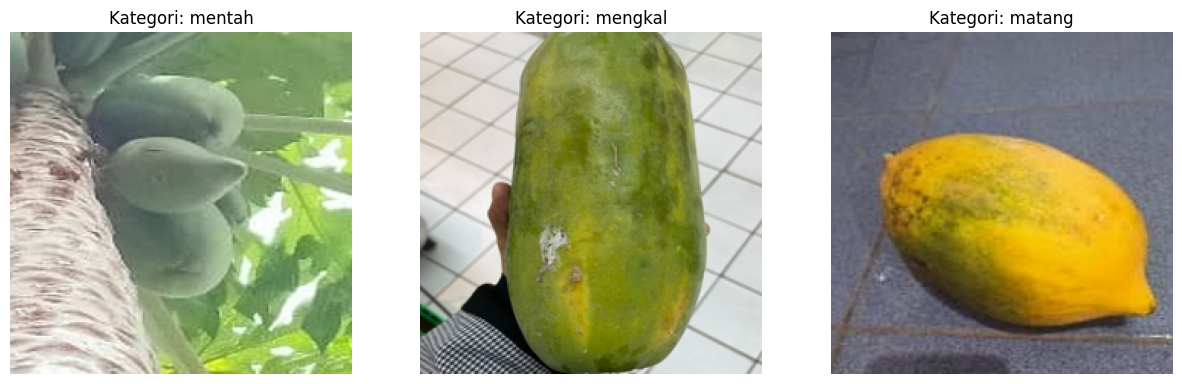

In [ ]:
# Menampilkan satu gambar per kelas
plt.figure(figsize=(15, 5))
for i, category in enumerate(['mentah', 'mengkal', 'matang']):
    # Mencari indeks gambar pertama dalam kategori ini
    index = df[df['category'] == category].index[0]

    # Menampilkan gambar
    plt.subplot(1, 3, i+1)
    plt.imshow(X[index])
    plt.title(f"Kategori: {category}")
    plt.axis('off')

plt.show()


In [ ]:
def extract_color_features(image):
  # Konversi ke ruang warna RGB
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Hitung rata-rata nilai RGB
  mean_rgb = np.mean(rgb_image, axis=(0, 1))

  # Konversi ke ruang warna HSV
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Hitung rata-rata nilai HSV
  mean_hsv = np.mean(hsv_image, axis=(0, 1))

  # Gabungkan fitur warna RGB dan HSV
  color_features = np.concatenate((mean_rgb, mean_hsv))

  return color_features

# Inisialisasi list untuk menyimpan fitur warna
color_features_list = []

# Ekstrak fitur warna untuk setiap gambar
for image in X:
  color_features = extract_color_features(image)
  color_features_list.append(color_features)

# Konversi list fitur warna ke array numpy
color_features_array = np.array(color_features_list)

print("Fitur warna telah diekstrak.")


Fitur warna telah diekstrak.


In [ ]:
# Cek bentuk array fitur warna
print("Bentuk array fitur warna:", color_features_array.shape)

# Cetak beberapa fitur warna pertama untuk verifikasi
print("Beberapa fitur warna pertama:")
print(color_features_array[:5])


Bentuk array fitur warna: (500, 6)
Beberapa fitur warna pertama:
[[131.77812101 166.73756378 150.00097656  75.77074697  58.26576451
  169.11501515]
 [ 40.20661272 125.51658163 107.83966438  77.85038664 211.21619898
  129.67141661]
 [ 90.57346142 131.67159598 105.91193001  62.31142379 118.58328683
  133.44182478]
 [121.1453683  160.2437221  138.29771205  66.30416932  85.38444675
  164.24697066]
 [ 78.52708466  94.45707111  82.19748485  61.12430246  72.04107541
   99.06624681]]


In [ ]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler ke data fitur warna dan transform data
scaled_color_features = scaler.fit_transform(color_features_array)

print("Data augmentasi pada fitur warna telah selesai.")

# Cetak beberapa fitur warna yang telah diskalakan untuk verifikasi
print("Beberapa fitur warna yang telah diskalakan:")
print(scaled_color_features[:5])


Data augmentasi pada fitur warna telah selesai.
Beberapa fitur warna yang telah diskalakan:
[[ 2.4919202   1.61534798  0.90213771 -0.25499593 -1.73406408  1.16999657]
 [-1.10494698  0.42099481 -0.21247395 -0.1308076   2.10663324  0.03824922]
 [ 0.87342892  0.59933265 -0.26343714 -1.05873655 -0.21944696  0.14643279]
 [ 2.07427283  1.42719282  0.59274043 -0.82030467 -1.05309413  1.03031874]
 [ 0.40025535 -0.47893582 -0.89037201 -1.12962701 -1.38815594 -0.83989885]]


In [ ]:
# Cetak ukuran shape dari scaled_color_features
print("Ukuran shape dari scaled_color_features:", scaled_color_features.shape)


Ukuran shape dari scaled_color_features: (500, 6)


In [ ]:
# Definisikan model InceptionV3 yang telah dioptimasi
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan lapisan-lapisan dasar
for layer in base_model.layers:
  layer.trainable = False

# Tambahkan lapisan-lapisan baru di atas model dasar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Tambahkan lapisan input untuk fitur warna
color_input = Input(shape=(scaled_color_features.shape[1],))
color_dense = Dense(64, activation='relu')(color_input)

# Gabungkan fitur warna dengan output dari model InceptionV3
combined_features = tf.keras.layers.concatenate([x, color_dense])

# Tambahkan lapisan output untuk klasifikasi
predictions = Dense(3, activation='softmax')(combined_features)  # 3 kelas untuk klasifikasi

# Buat model akhir
model = Model(inputs=[base_model.input, color_input], outputs=predictions)

# Cetak ringkasan model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,066,083 (84.18 MB)

 Trainable params: 263,299 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.save('papaya_model.h5')


In [ ]:
# Load the saved model
loaded_model = load_model('/content/papaya_model.h5')

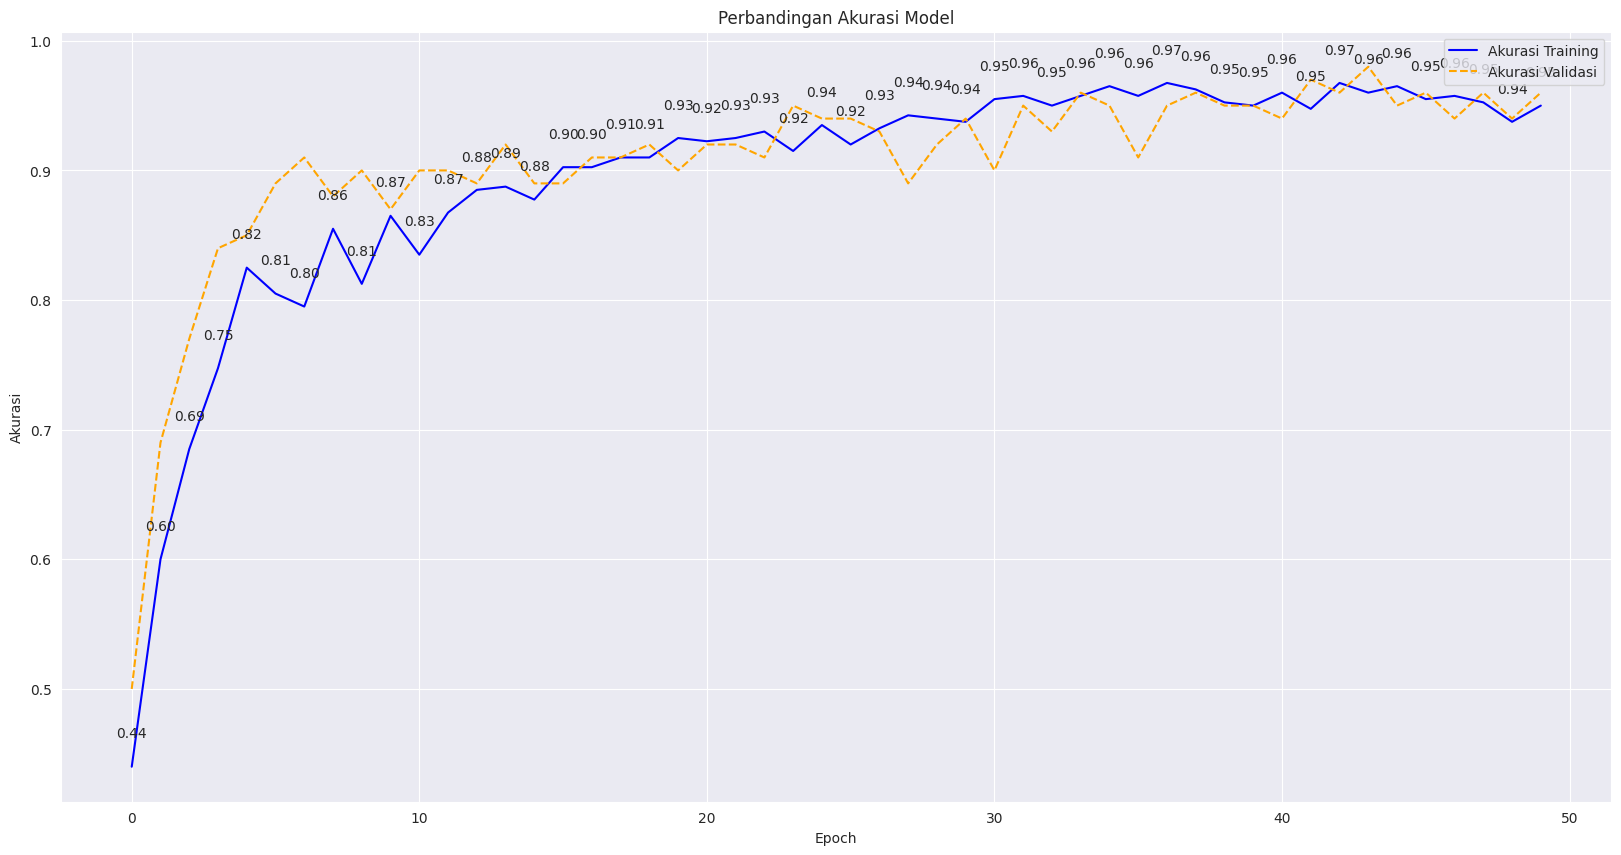

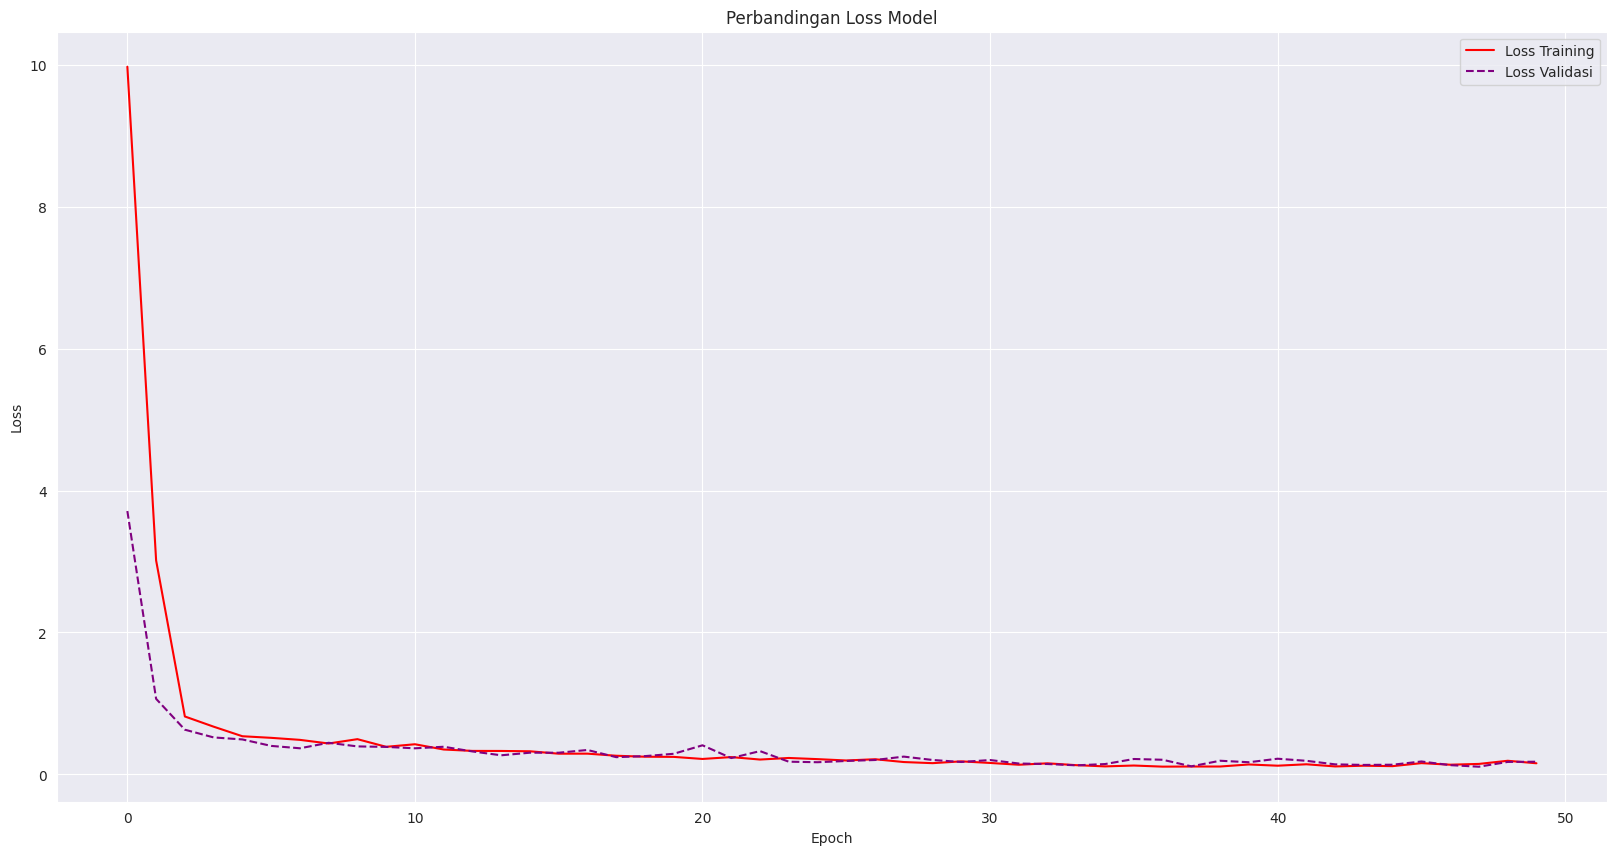

In [ ]:
# Load the saved model and training history
# ... (as in your original code)

# Set a custom style (optional)
sns.set_style("darkgrid")

# Plot accuracy curve with more customization
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label='Akurasi Training', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi', color='orange', linestyle='--')
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Add epoch annotations with a loop
for i, acc in enumerate(history.history['accuracy']):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')

# Plot loss curve with more customization
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Loss Training', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Loss Validasi', color='purple', linestyle='--')
plt.title('Perbandingan Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


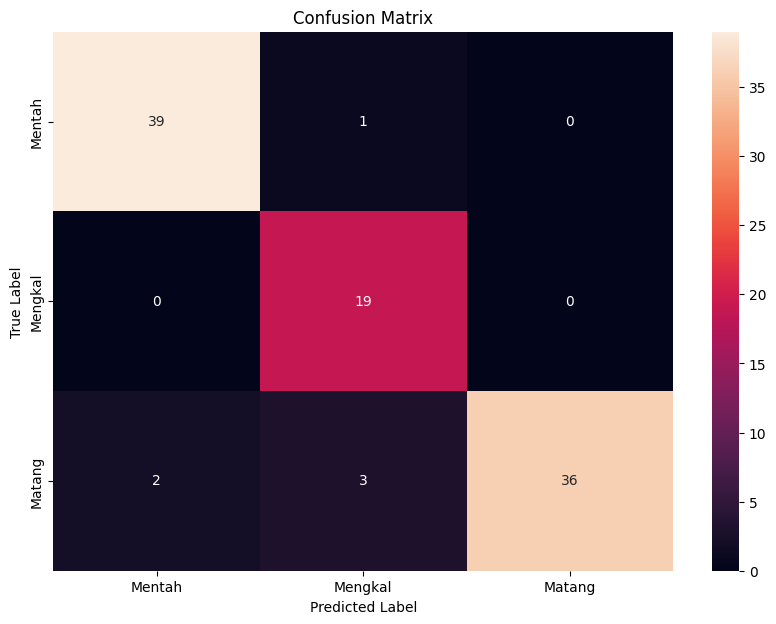

              precision    recall  f1-score   support

      Mentah       0.95      0.97      0.96        40
     Mengkal       0.83      1.00      0.90        19
      Matang       1.00      0.88      0.94        41

    accuracy                           0.94       100
   macro avg       0.93      0.95      0.93       100
weighted avg       0.95      0.94      0.94       100



In [ ]:

# Prediksi pada data validasi
y_pred_probs = loaded_model.predict([X_val_images, X_val_color])
y_pred = np.argmax(y_pred_probs, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Tampilkan confusion matrix dengan label kelas
class_names = ['Mentah', 'Mengkal', 'Matang']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Cetak laporan klasifikasi
print(classification_report(y_val, y_pred, target_names=class_names))


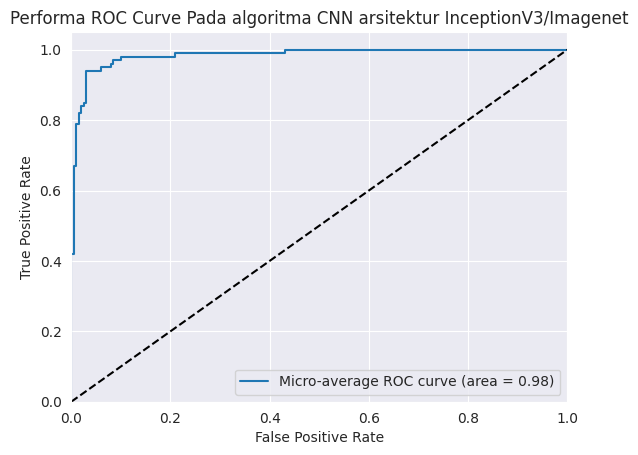

In [ ]:
# Binarize the output
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Performa ROC Curve Pada algoritma CNN arsitektur InceptionV3/Imagenet')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Prediksi pada data validasi
y_pred_probs = loaded_model.predict([X_val_images, X_val_color])
y_pred = np.argmax(y_pred_probs, axis=1)

# Hitung presisi, recall, dan F1-score untuk setiap kelas
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

# Hitung akurasi untuk setiap kelas
accuracy = []
for i in range(3):
  true_positives = np.sum((y_val == i) & (y_pred == i))
  total_samples = np.sum(y_val == i)
  accuracy.append(true_positives / total_samples if total_samples > 0 else 0)

# Cetak laporan
class_names = ['Mentah', 'Mengkal', 'Matang']
print("Laporan Akurasi dan Loss per Kelas:")
for i in range(3):
  print(f"Kelas {class_names[i]}:")
  print(f"  Akurasi: {accuracy[i]:.2f}")
  print(f"  Presisi: {precision[i]:.2f}")
  print(f"  Recall: {recall[i]:.2f}")
  print(f"  F1-score: {f1_score[i]:.2f}")
  print()


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Laporan Akurasi dan Loss per Kelas:
Kelas Mentah:
  Akurasi: 0.97
  Presisi: 0.95
  Recall: 0.97
  F1-score: 0.96

Kelas Mengkal:
  Akurasi: 1.00
  Presisi: 0.83
  Recall: 1.00
  F1-score: 0.90

Kelas Matang:
  Akurasi: 0.88
  Presisi: 1.00
  Recall: 0.88
  F1-score: 0.94



Saving manfaat-konsumsi-pepaya-muda-untuk-kesehatan_48_20200717230235.jpg to manfaat-konsumsi-pepaya-muda-untuk-kesehatan_48_20200717230235 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
mentah


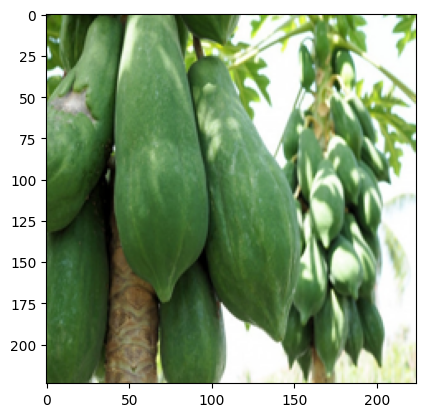

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = preprocess_image(path)

  # Convert the image to RGB if it has an alpha channel
  if img.shape[2] == 4:  # Check if the image has 4 channels
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)  # Convert RGBA to RGB

  x = np.expand_dims(img, axis=0)

  # Ekstrak fitur warna dari gambar yang diunggah
  color_features_uploaded = extract_color_features(img)

  # Skala fitur warna menggunakan scaler yang sama yang digunakan untuk data pelatihan
  scaled_color_features_uploaded = scaler.transform(color_features_uploaded.reshape(1, -1))

  images = np.vstack([x])
  classes = loaded_model.predict([images, scaled_color_features_uploaded], batch_size=10)
  result = np.argmax(classes)

  if result == 0:
    print("mentah")
    plt.imshow(img)
  elif result == 1:
    print('mengkal')
    plt.imshow(img)
  elif result == 2:
    print('matang')
    plt.imshow(img)